In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

# Load dataset
file_path = "../merged_nfl.csv"
df = pd.read_csv(file_path)

# Select relevant columns
df = df[['Player_df2_x', 'Pos', 'Pageviews', 'PaYds', 'PaTD', 'RecYds', 'RecTD', 'RuYds', 'RuTD', 'Solo', 'Ast', 'Sfty']]

# Rename for clarity
df.rename(columns={'Player_df2_x': 'Player'}, inplace=True)

# Fill missing values with 0
df.fillna(0, inplace=True)

# Display first rows
df.head()


,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty
0,Kyler Murray,QB,845475.0,19498,115,7,0,3020,31,0,0,0
1,Clayton Tune,QB,56850.0,70,0,0,0,26,1,0,0,0
2,Trey Benson,RB,110208.0,0,0,59,0,291,1,0,0,0
3,Michael Carter,RB,50197.0,0,0,771,1,1359,8,1,0,0
4,James Conner,RB,198361.0,0,0,2217,11,5970,59,2,0,0


In [5]:

# Apply log transformation to Pageviews
df['Log_Pageviews'] = np.log1p(df['Pageviews'])

# Features for clustering
features = ['PaYds', 'PaTD', 'RecYds', 'RecTD', 'RuYds', 'RuTD', 'Solo', 'Ast', 'Sfty', 'Log_Pageviews']

# Standardize features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

df_scaled.head()


,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty,Log_Pageviews
0,Kyler Murray,QB,845475.0,5.335265,4.663330,-0.262428,-0.255799,4.140510,5.068836,-0.479047,-0.482062,-0.129008,2.038831
1,Clayton Tune,QB,56850.0,-0.108825,-0.121126,-0.268481,-0.255799,-0.166588,-0.023797,-0.479047,-0.482062,-0.129008,0.282716
2,Trey Benson,RB,110208.0,-0.128440,-0.121126,-0.217460,-0.255799,0.214634,-0.023797,-0.479047,-0.482062,-0.129008,0.713338
3,Michael Carter,RB,50197.0,-0.128440,-0.121126,0.398251,-0.126810,1.751034,1.164484,-0.469718,-0.482062,-0.129008,0.201750
4,James Conner,RB,198361.0,-0.128440,-0.121126,1.648699,1.163084,8.384311,9.821959,-0.460390,-0.482062,-0.129008,1.095672


In [6]:

# Compute mean feature vector per position
position_means = df_scaled.groupby("Pos")[features].mean()

# Compute Euclidean distance from position mean (deviation from norm)
def distance_from_position_mean(row):
    pos = row['Pos']
    if pos in position_means.index:
        return euclidean(row[features], position_means.loc[pos])
    return None

df_scaled['DeviationFromPosition'] = df_scaled.apply(distance_from_position_mean, axis=1)

# Compute Obscurity Score: Deviation adjusted by inverse Log_Pageviews
df_scaled['ObscurityRaw'] = df_scaled['DeviationFromPosition'] / df_scaled['Log_Pageviews']

# Normalize the obscurity score
scaler = MinMaxScaler()
df_scaled['ObscurityScore'] = scaler.fit_transform(df_scaled[['ObscurityRaw']])

# Sort by highest obscurity
df_sorted = df_scaled.sort_values(by='ObscurityScore', ascending=False)
df_sorted[['Player', 'Pos', 'Pageviews', 'ObscurityScore']].head(10)


,Player,Pos,Pageviews,ObscurityScore
2044,Joe Tryon-Shoyinka,OLB,36851.0,1.000000
479,David Bell,WR,36964.0,0.863809
757,Chris Brooks,RB,37420.0,0.701438
1179,Teair Tart,DT,36968.0,0.686144
1966,Pharaoh Brown,TE,37005.0,0.676191
1916,George Holani,RB,37752.0,0.675016
1968,Artie Burns,CB,39707.0,0.654182
1460,Jahlani Tavai,RILB,38016.0,0.652927
1704,Tyrion Davis-Price,RB,38085.0,0.651063
5,DeeJay Dallas,RB,37810.0,0.642414


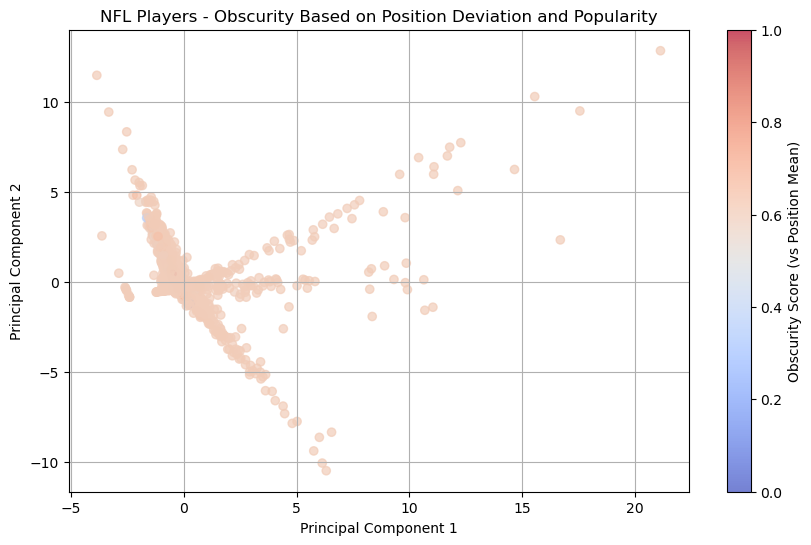

In [7]:

# Reduce dimensions with PCA
pca = PCA(n_components=2)
proj = pca.fit_transform(df_scaled[features])

# Plot with obscurity coloring
plt.figure(figsize=(10,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=df_scaled['ObscurityScore'], cmap='coolwarm', alpha=0.7)
plt.colorbar(label="Obscurity Score (vs Position Mean)")
plt.title("NFL Players - Obscurity Based on Position Deviation and Popularity")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [8]:
df_sorted.tail(25)

,Player,Pos,Pageviews,PaYds,PaTD,RecYds,RecTD,RuYds,RuTD,Solo,Ast,Sfty,Log_Pageviews,DeviationFromPosition,ObscurityRaw,ObscurityScore
2137,Tyree Jackson,SS,32586.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,6.414784,3.373033,-0.129008,-0.079324,3.884939,-48.975629,0.569071
739,Al-Quadin Muhammad,DL,35561.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,0.556427,0.521319,-0.129008,-0.022490,1.149607,-51.116650,0.568050
1344,Anthony Walker Jr.,LB,32908.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,2.897904,3.373033,-0.129008,-0.072927,3.731308,-51.164751,0.568027
216,Tyrell Shavers,WR,34767.0,-0.12844,-0.121126,-0.208813,-0.126810,-0.203991,-0.193551,-0.479047,-0.482062,-0.129008,-0.037179,1.910553,-51.387623,0.567920
713,Mekhi Wingo,DL,35646.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,-0.469718,-0.341236,-0.129008,-0.020937,1.162497,-55.524083,0.565947
346,Tyler Scott,WR,35063.0,-0.12844,-0.121126,-0.118877,-0.255799,-0.145010,-0.193551,-0.469718,-0.482062,-0.129008,-0.031664,1.931796,-61.008730,0.563330
1601,Andru Phillips,DE,33517.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,2.823275,2.704113,-0.129008,-0.060999,3.800098,-62.297997,0.562714
1374,Levi Drake Rodriguez,DL,35806.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,-0.469718,-0.482062,-0.129008,-0.018023,1.234601,-68.499877,0.559755
1477,JaMycal Hasty,RB,35377.0,-0.12844,-0.121126,0.055805,0.002179,0.485087,0.485467,-0.413747,-0.464459,-0.129008,-0.025865,1.859856,-71.907530,0.558129
741,Pat O'Connor,DL,33098.0,-0.12844,-0.121126,-0.268481,-0.255799,-0.203991,-0.193551,-0.301803,-0.077189,6.292092,-0.069182,5.561054,-80.382701,0.554085
